In [1]:
import argparse
import torch
import numpy as np
import os
import json
from tqdm import tqdm
import re
import jsonlines
import PIL.Image as Image
import pickle as pkl
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
Image.MAX_IMAGE_PIXELS = None

In [20]:
# bench_json_path = "/media/zilun/fanxiang4t/GRSM/ImageRAG_git/data/train/FIT-RS-train-1415k_5para.json"
output_file_path = "/media/zilun/fanxiang4t/GRSM/ImageRAG_git/data/train/AGMLLLM_final_5para_star_obb2_0-1000.jsonl"
star_stats_path = "/media/zilun/fanxiang4t/GRSM/ImageRAG_git/codebase/dataset_process/star_statistics.pkl"
fit_img_dir = "/media/zilun/fanxiang4t/GRSM/evaluation_dataset/VQA_VG/FIT/FIT-RS/FIT-RS_Instruction/FIT-RS_Img/imgv2_split_512_100_vaild"
star_stats = pkl.load(open(star_stats_path, "rb"))

In [21]:
item_id = 27

In [22]:
def read_jsonl(jsonl_path):
    base = [json.loads(q) for q in open(jsonl_path, "r")]
    return base

def read_json(json_path):
    with open(json_path, "r") as f:
        base = json.load(f)
    return base

In [23]:
json_content = read_jsonl(output_file_path)
# json_content = read_json(output_file_path)

In [24]:
len(json_content)

1415474

In [25]:
def get_item_by_id(json_content, item_id):
    print(item_id)
    for content in tqdm(json_content):
        if content["id"] == item_id:
            print(content["id"])
            return content

In [26]:
vis_data = get_item_by_id(json_content, item_id)

27


  0%|                                                                                                                                                                                                                                      | 8/1415474 [00:00<00:15, 90933.42it/s]

27


In [27]:
vis_data

{'id': 27,
 'image': '0000.png',
 'height': 2048,
 'width': 3584,
 'train_task_type': 'complex_compare',
 'additional_roi_coord': {'fit': [[0.0,
    402.34375,
    142.85714285714286,
    652.34375]],
  'object': [[20.807072477999423,
    610.7169974009385,
    25.250072776953143,
    652.2205102284561],
   [0.0, 290.7343895008035, 30.80575237909087, 881.1031120250756],
   [0.0, 290.7343895008035, 30.80575237909087, 881.1031120250756]]},
 'conversations': [{'from': 'human',
   'value': "<image>\nAdditional information:\nRegion of Interest: <box>[[0.00, 402.34, 142.86, 652.34]]</box>: <image>\nUnion patch of targets: <box>[[0.00, 290.73, 30.81, 881.10]]</box>: <image>\nSub-patch 1 at location <box>[[20.81, 610.72, 25.25, 652.22]]</box>: <image>\nSub-patch 2 at location <box>[[0.00, 290.73, 30.81, 881.10]]</box>: <image>\nLook at center-left of the image and answer the question: \n[detection]In the image, what's the relationship between <ref>ship</ref><rbox>({<21.64><615.58><24.42><647.3

In [28]:
def star_denormalization(rbbox, image_w, image_h):
    """obb2poly_np_oc_2rad
    rbbox: normalzied rbbox
    return: unnormalized rbbox (deg angle)
    """
    x1, y1, x2, y2 = rbbox
    x1 = x1 / 1000 * image_w
    y1 = y1 / 1000 * image_h
    x2 = x2 / 1000 * image_w
    y2 = y2 / 1000 * image_h
    # angle_rad = math.radians(angle_deg)
    return x1, y1, x2, y2

In [29]:
star_image_name = vis_data["image"]
star_image_w, star_image_h, star_image_dir = star_stats[star_image_name]
additional_roi_coord = vis_data["additional_roi_coord"]

In [30]:
star_image_w, star_image_h, star_image_dir
star_img_path = os.path.join(star_image_dir, star_image_name)

In [31]:
all_roi_coord = additional_roi_coord["fit"] + additional_roi_coord["object"]

In [32]:
def obb22obb1(rbbox):
    x1, y1, x2, y2 = rbbox
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return cx, cy, w, h


def vis_bbox(img_path, list_bbox, image_w, image_h, dataset_name):

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    def draw_rotated_box(ax, vertices, color='red', alpha=0.5):
        box = patches.Polygon(np.array(vertices).reshape(-1, 2), closed=True, edgecolor=color, facecolor='none',
                              linewidth=5, alpha=alpha)
        ax.add_patch(box)

    img = plt.imread(img_path)

    # 创建一个1行2列的子图
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))

    # 可视化真实旋转边界框
    # axs.imshow(img)
    axs.set_title('Ground Truth Rotated BBoxes')
    for obb2_bbox in list_bbox:
        x1, y1, x2, y2 = star_denormalization(obb2_bbox, image_w, image_h)
        print(x1, y1, x2, y2)
        p1x, p1y, p2x, p2y, p3x, p3y, p4x, p4y = x1, y1, x2, y1, x2, y2, x1, y2
        poly = np.array([[p1x, p1y], [p2x, p2y], [p3x, p3y], [p4x, p4y]])
        print(poly)
        draw_rotated_box(axs, poly, color='red')
    axs.axis('off')  # 关闭坐标轴
    # 在子图下方显示图片路径
    axs.set_xlabel(img_path)

    # 调整子图间距
    plt.tight_layout()
    # 显示图像
    plt.show()

In [33]:
# vis_bbox(star_img_path, all_roi_coord, star_image_w, star_image_h, "star")

In [34]:
def vis_bbox(img_path, bboxes, image_w, image_h, dataset_name):
    # 读取图片
    img = np.array(Image.open(img_path))
    
    # 创建一个图形和两个子图
    fig, ax = plt.subplots(figsize=(30, 30))
    
    # 显示图片
    ax.imshow(img)
    
    # 遍历边界框列表，绘制每个边界框
    for bbox in bboxes:
        # 假设边界框格式为 (x1, y1, x2, y2)
        x1, y1, x2, y2 = star_denormalization(bbox, image_w, image_h)
        print(x1, y1, x2, y2)
        # 创建一个矩形并添加到子图
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    # 设置标题和轴标签
    ax.set_title(f'BBoxes Visualization - {dataset_name}')
    ax.set_xlabel(f'Image Width: {image_w}')
    ax.set_ylabel(f'Image Height: {image_h}')
    
    # 移除轴标记
    ax.axis('off')
    
    # 显示图形
    plt.show()

0.0 824.0 512.0 1336.0
74.57254776114993 1250.748410677122 90.49626083260006 1335.747604947878
0.0 595.4240296976456 110.40781652666168 1804.499173427355
0.0 595.4240296976456 110.40781652666168 1804.499173427355


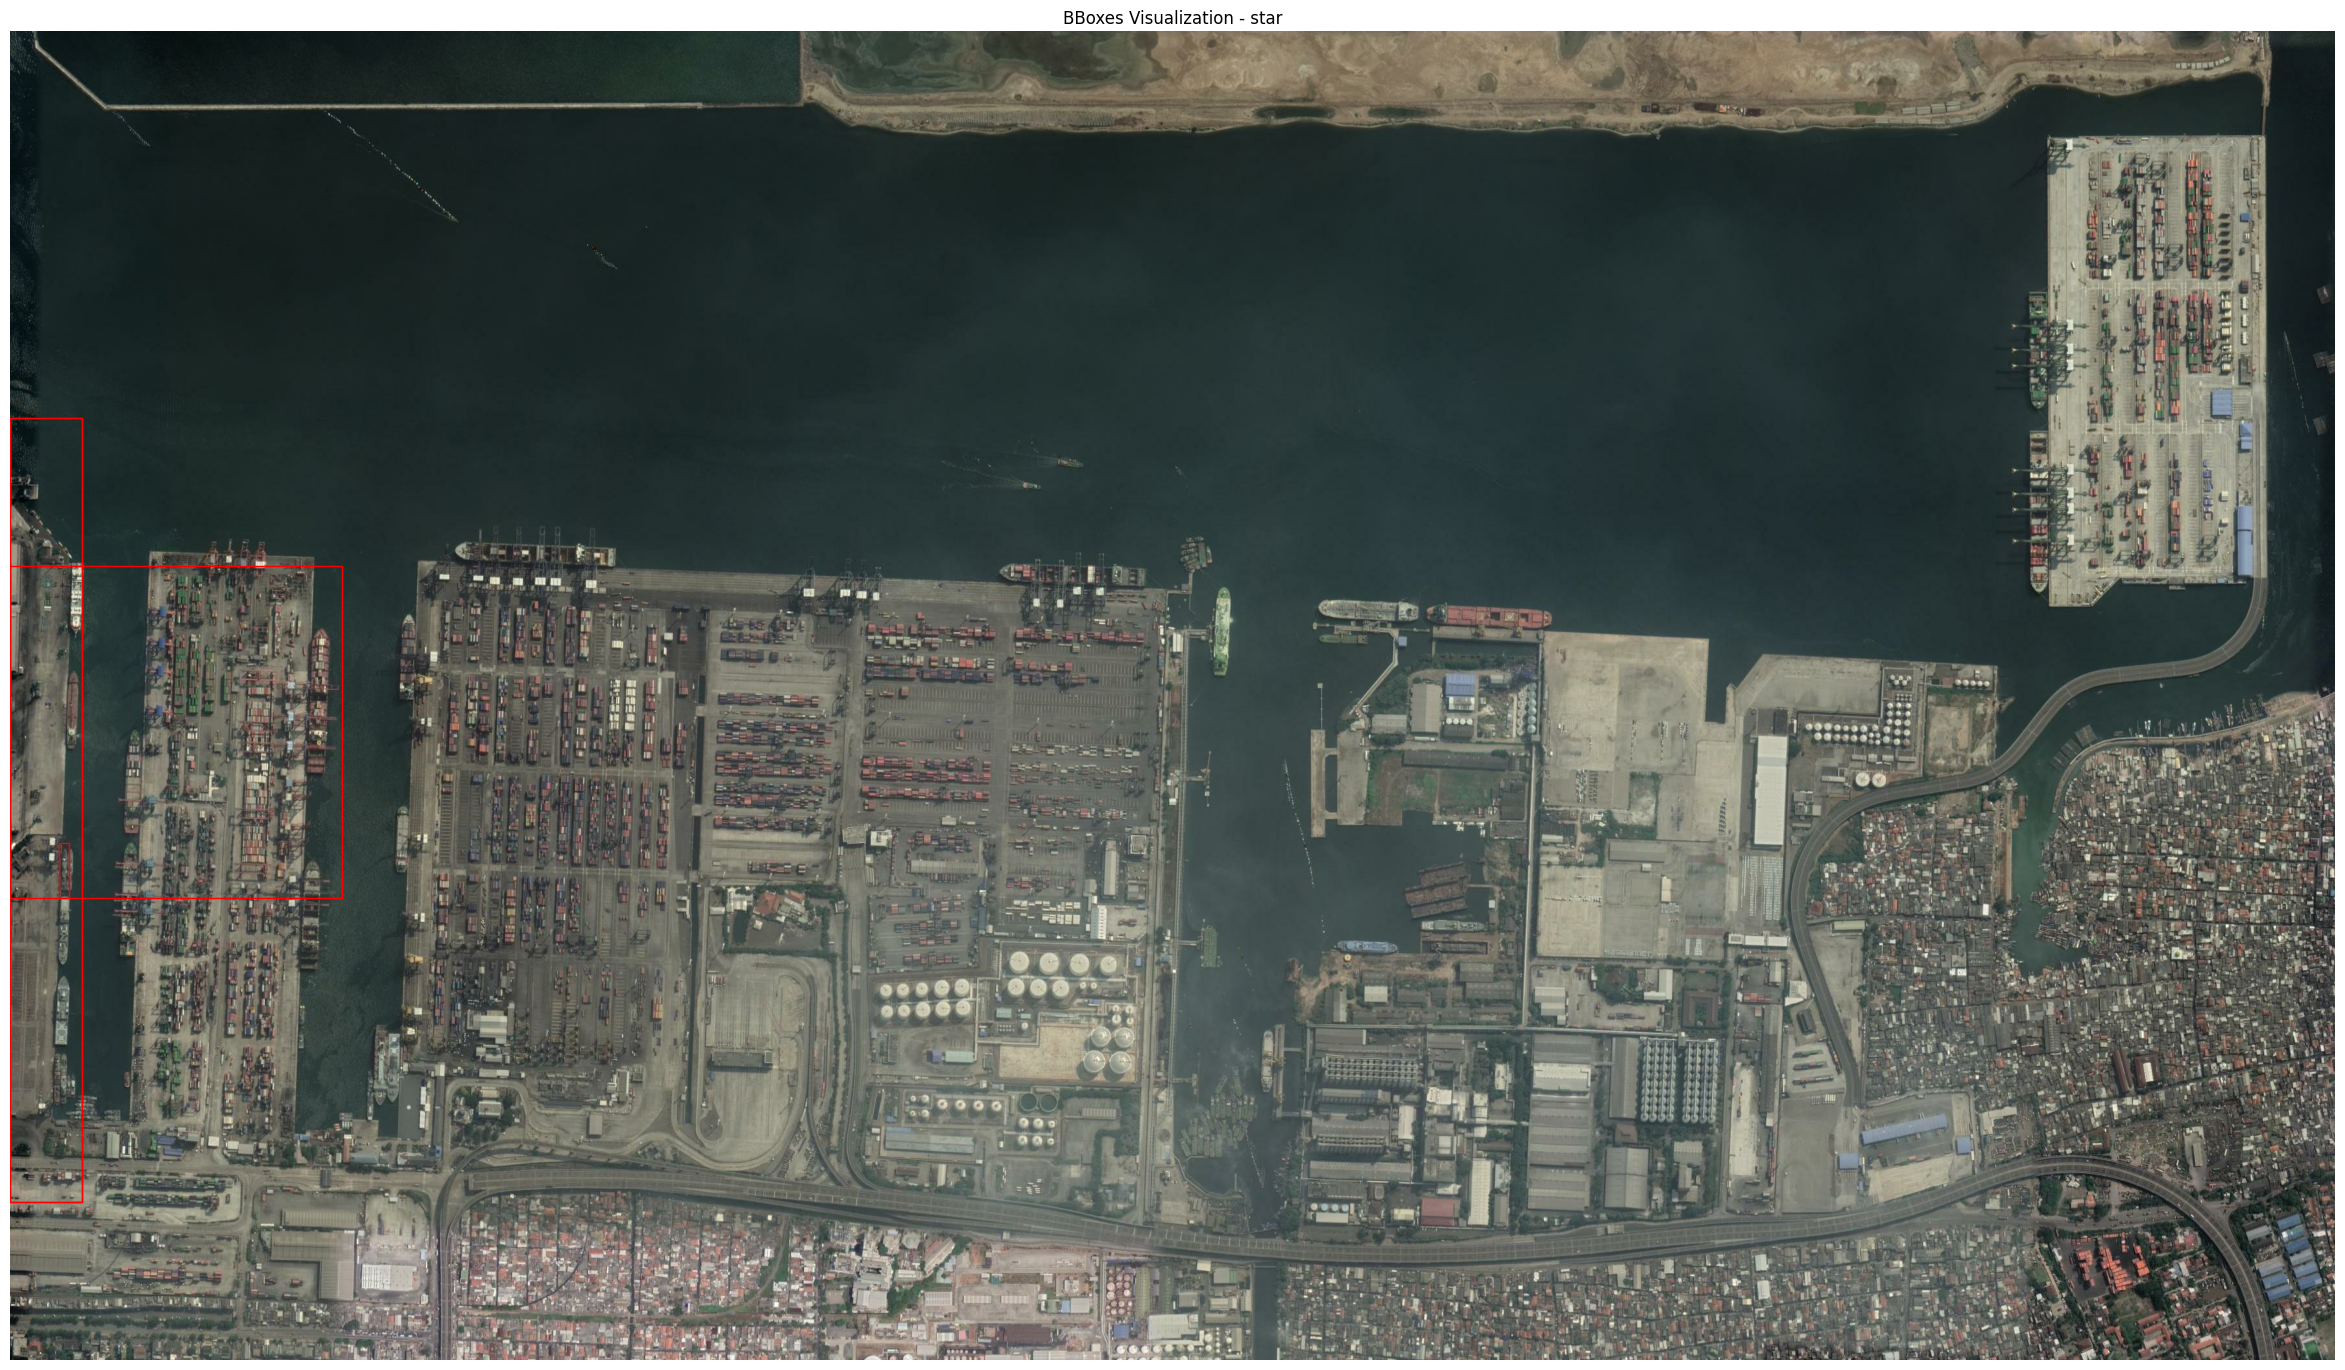

In [35]:
vis_bbox(star_img_path, all_roi_coord, star_image_w, star_image_h, "star")